In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
import os
import warnings
from matplotlib import pyplot as plt


warnings.filterwarnings("ignore")



###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
yielddatadirectory=directory+"/data/yielddata/bonddefiniton.csv"
marketdatadirectory=directory+"/data/marketdata/marketdata.csv"
bonddefinition=directory+"/data/yielddata/bonddefinition.xlsm"


bonddefiniton = pd.read_csv(yielddatadirectory)
marketdata = pd.read_csv(marketdatadirectory)
bondslist=pd.read_excel(bonddefinition,engine='openpyxl')

data=bonddefiniton.merge(marketdata[['valuationDate','isinCode','value']], left_on='isinCode', right_on='isinCode')


In [2]:
# Fill bond trade information
bonddata={}
bonddata["notional"]=100
bonddata["valuationDate"]="2021-03-05"
bonddata["settlementDate"]="2021-03-09"
bonddata["buySell"]="Sell"
bonddata

{'notional': 100,
 'valuationDate': '2021-03-05',
 'settlementDate': '2021-03-09',
 'buySell': 'Sell'}

In [3]:
instruments={}
bonds={}
bonds["settlementDays"]=2
instruments["BONDS"]=bonds
instruments

{'BONDS': {'settlementDays': 2}}

In [4]:
#Define discount curve parameter for pricing bonds.
discountCurve={}
discountCurve["settlementDays"]=2
discountCurve["calendar"]="NullCalendar" 
discountCurve["currency"]="USD" # Currency is using filter yield data. Only same currency datas are filtered for bond calculation
discountCurve["dayCounter"]="Thirty360" # Default value is Actual360
discountCurve["period"]="6M" # Can not use if instruments selected BONDS
discountCurve["intpMethod"]="Linear" # if method is not null, it will not used
discountCurve["instruments"]=instruments
discountCurve

{'settlementDays': 2,
 'calendar': 'NullCalendar',
 'currency': 'USD',
 'dayCounter': 'Thirty360',
 'period': '6M',
 'intpMethod': 'Linear',
 'instruments': {'BONDS': {'settlementDays': 2}}}

In [5]:
yieldData=data.to_dict('r')

In [6]:
selectbonds=['US900123DA57','US900123AY60','US900123CG37','US900123CT57','US900123CJ75','US900123CY43','US900123BY51',
             'US900123CA66','US900123CV04','US900123CP36','US900123CX69','US900123CL22','US900123BG46']

In [7]:
selectedbonds_df=bondslist[bondslist['ISIN'].isin(selectbonds)]
selectedbonds_df=selectedbonds_df.sort_values(by=['Maturity'])

In [8]:
def convertfrequency(num):
    if num==1:
        res="Annual"
    elif num==2:
        res="Semiannual"
    return res    

In [9]:
fixedRateBondDefinition={}
ytmdicts={}
bbgytmdicts={}
for row,index in selectedbonds_df.iterrows():
    fixedRateBondDefinition["coupon"]=index['Coupon']/100
    fixedRateBondDefinition["issueDate"]=index['Issue Date'].strftime("%Y-%m-%d")
    fixedRateBondDefinition["maturityDate"]=index['Maturity'].strftime("%Y-%m-%d")
    fixedRateBondDefinition["frequency"]=convertfrequency(index["Coupon Frequency"])
    fixedRateBondDefinition["calendar"]="Turkey"
    fixedRateBondDefinition["businessDayConvention"]="Unadjusted"
    fixedRateBondDefinition["maturityDateConvention"]="Unadjusted"
    fixedRateBondDefinition["dateGeneration"]="Backward"
    fixedRateBondDefinition["endOfMonth"]=True
    fixedRateBondDefinition["currency"]=index['Currency']
    fixedRateBondDefinition["dayCounter"]="Thirty360"
    fixedRateBondDefinition["redemption"]=100
    bonddata['fixedRateBondDefinition']=fixedRateBondDefinition
    bonddata['discountCurve']=discountCurve
    bonddata['yieldData']=yieldData
    try:
        data = api.createTask(CalculationType.FIXED_RATE_BOND, bonddata,True)
        result=json.loads(data["result"])
    except RhoovaError as e:
        e.printPretty()    
    bloombergytm=(index['Ask Yield to Maturity']+index['Bid Yield to Maturity'])/2
    ytmdicts[index['Maturity']] = 100*result.get('yieldToMaturity')
    bbgytmdicts[index['Maturity']] = bloombergytm

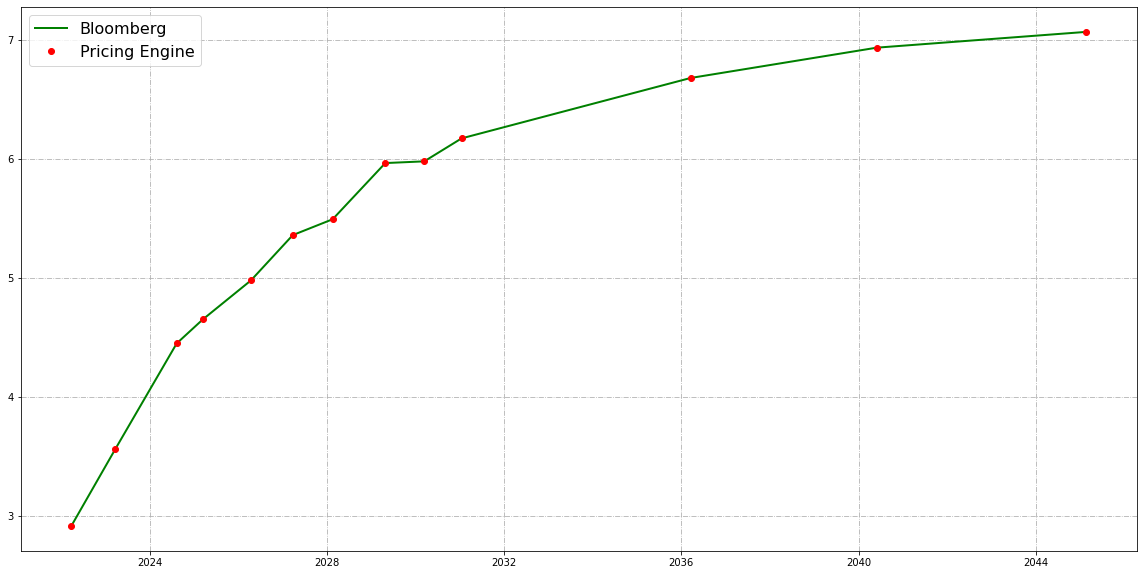

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(bbgytmdicts.keys())
y1 =list(bbgytmdicts.values())
y2 = list(ytmdicts.values())

ax.plot(x,y1, 'g', label='Bloomberg', linewidth=2)
ax.plot(x,y2, 'ro', label='Pricing Engine', linewidth=8)
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [11]:
pTable = pt.PrettyTable(['Maturity', 'YTM',"Bloomberg YTM"])
for key, val in ytmdicts.items():
    pTable.add_row([key, val,bbgytmdicts[key]])
pTable.align = 'c'
pTable.float_format = '.4'
print(pTable)

+---------------------+--------+---------------+
|       Maturity      |  YTM   | Bloomberg YTM |
+---------------------+--------+---------------+
| 2022-03-25 00:00:00 | 2.9143 |     2.9149    |
| 2023-03-23 00:00:00 | 3.5623 |     3.5625    |
| 2024-08-10 00:00:00 | 4.4537 |     4.4512    |
| 2025-03-13 00:00:00 | 4.6527 |     4.6528    |
| 2026-04-14 00:00:00 | 4.9810 |     4.9812    |
| 2027-03-25 00:00:00 | 5.3623 |     5.3625    |
| 2028-02-17 00:00:00 | 5.4959 |     5.4960    |
| 2029-04-26 00:00:00 | 5.9689 |     5.9686    |
| 2030-03-13 00:00:00 | 5.9829 |     5.9830    |
| 2031-01-15 00:00:00 | 6.1783 |     6.1763    |
| 2036-03-17 00:00:00 | 6.6843 |     6.6844    |
| 2040-05-30 00:00:00 | 6.9385 |     6.9395    |
| 2045-02-17 00:00:00 | 7.0720 |     7.0721    |
+---------------------+--------+---------------+


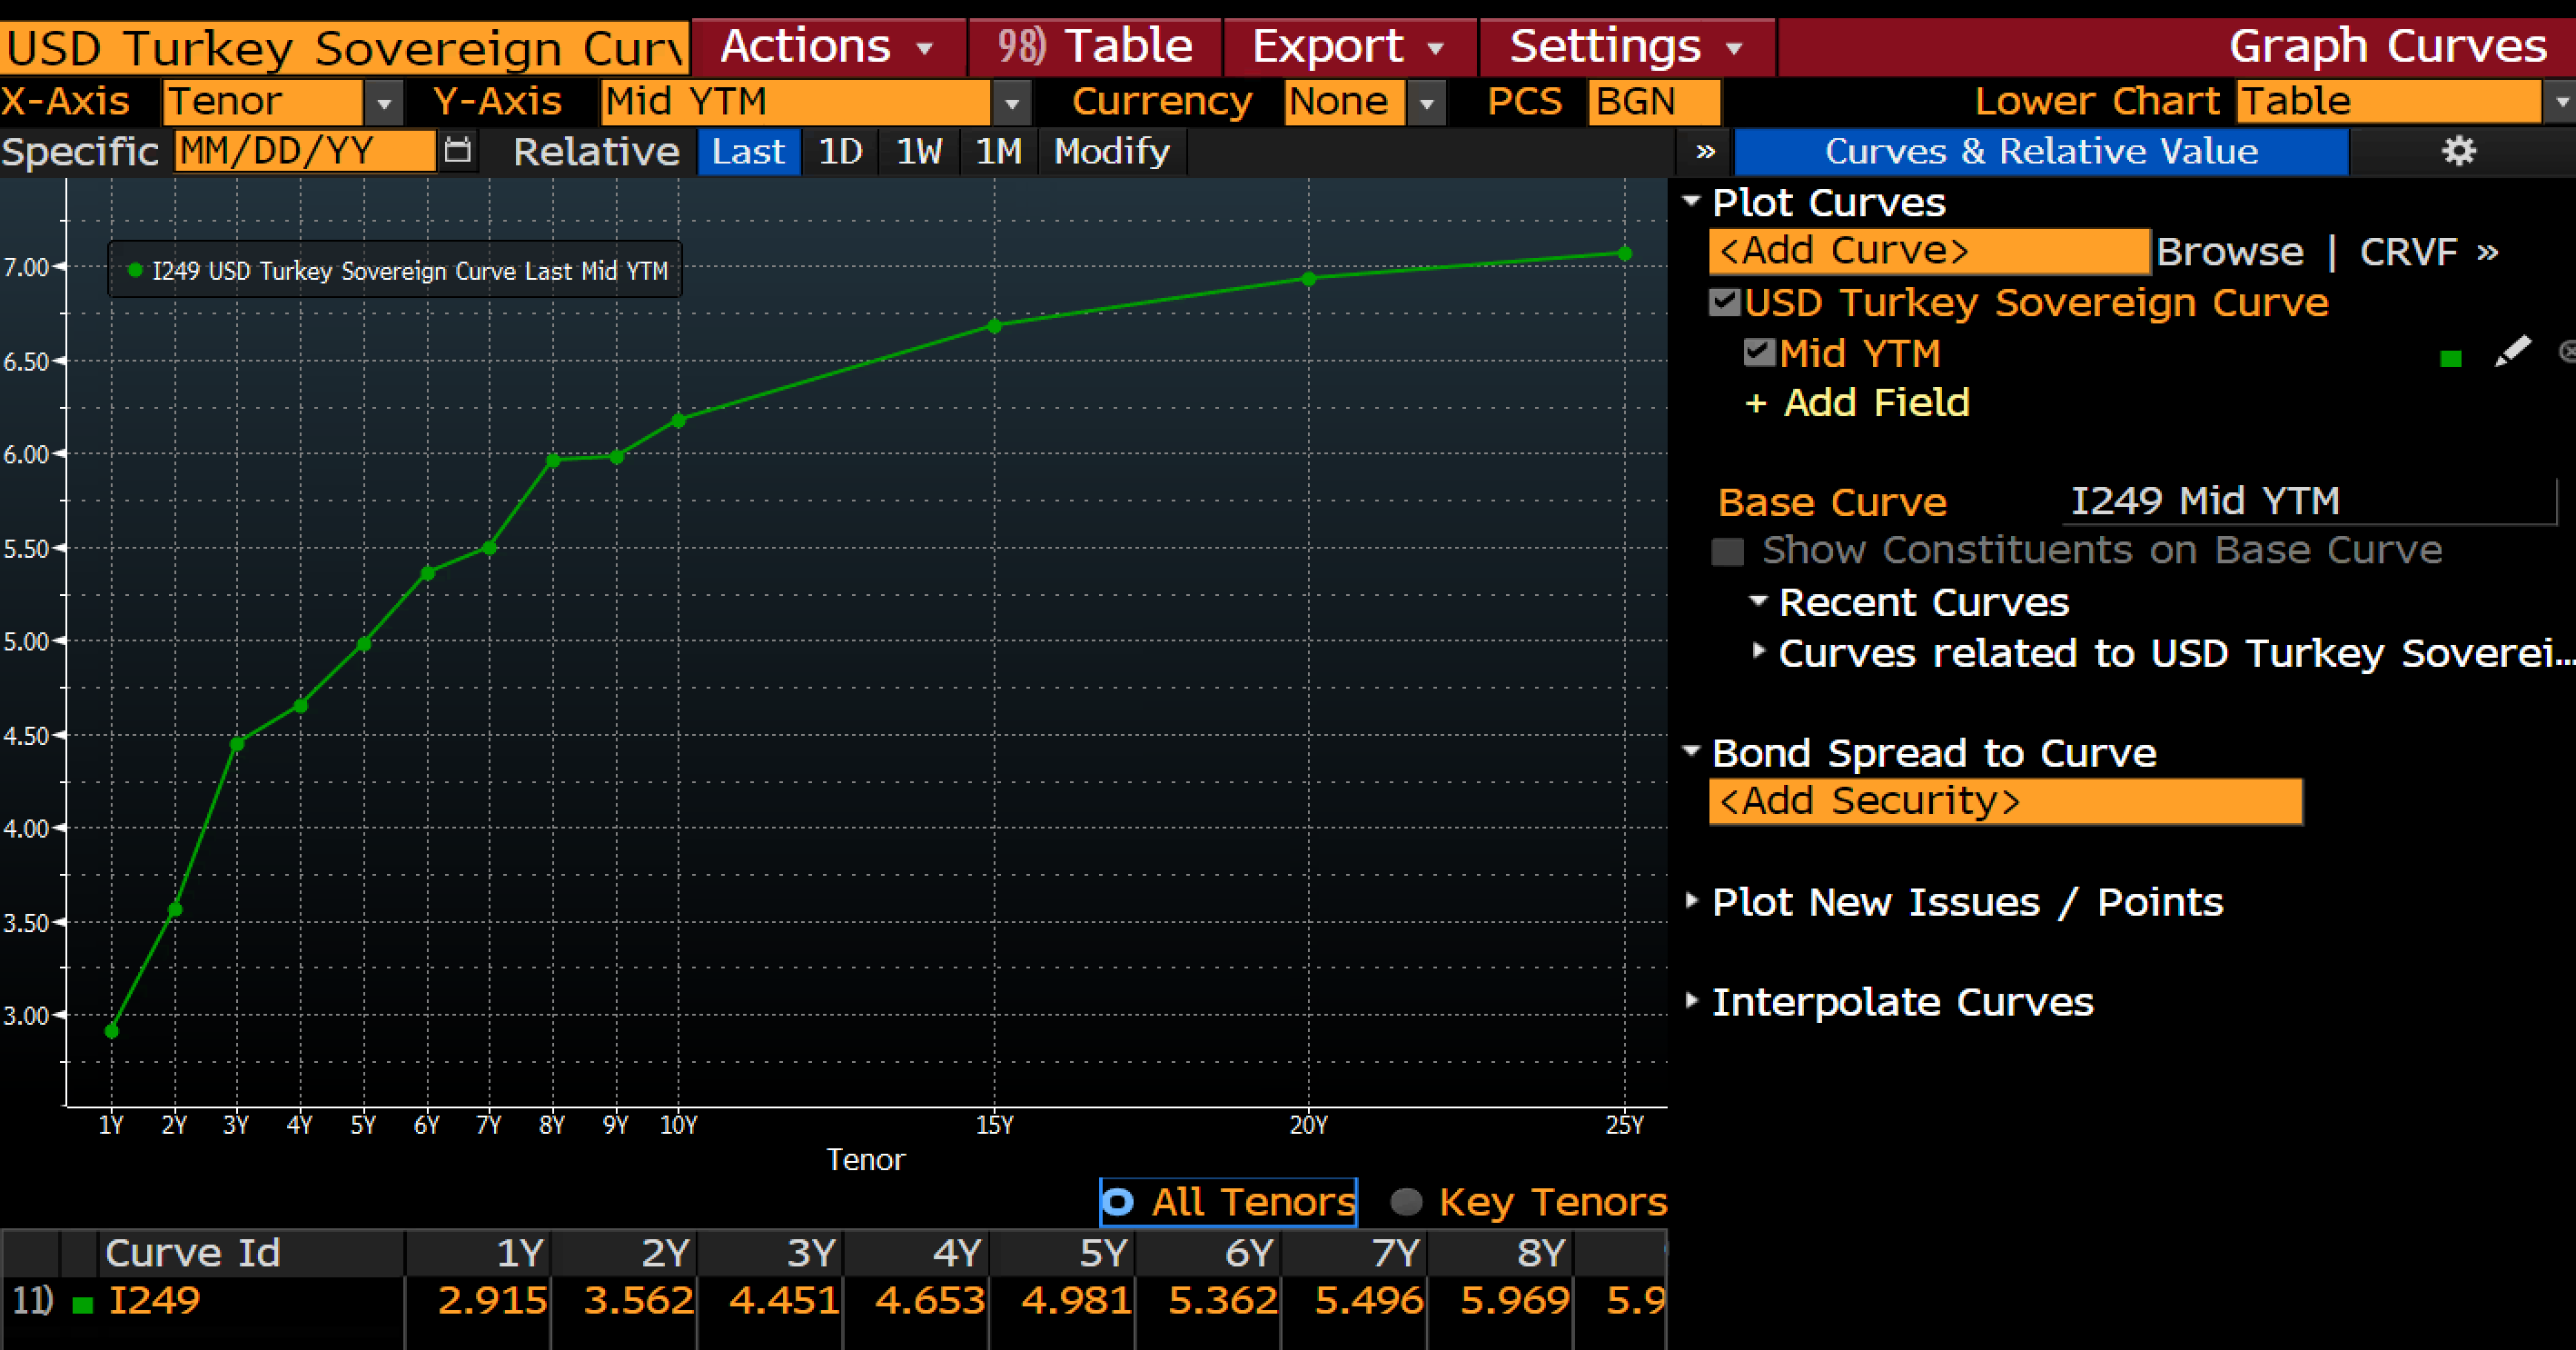

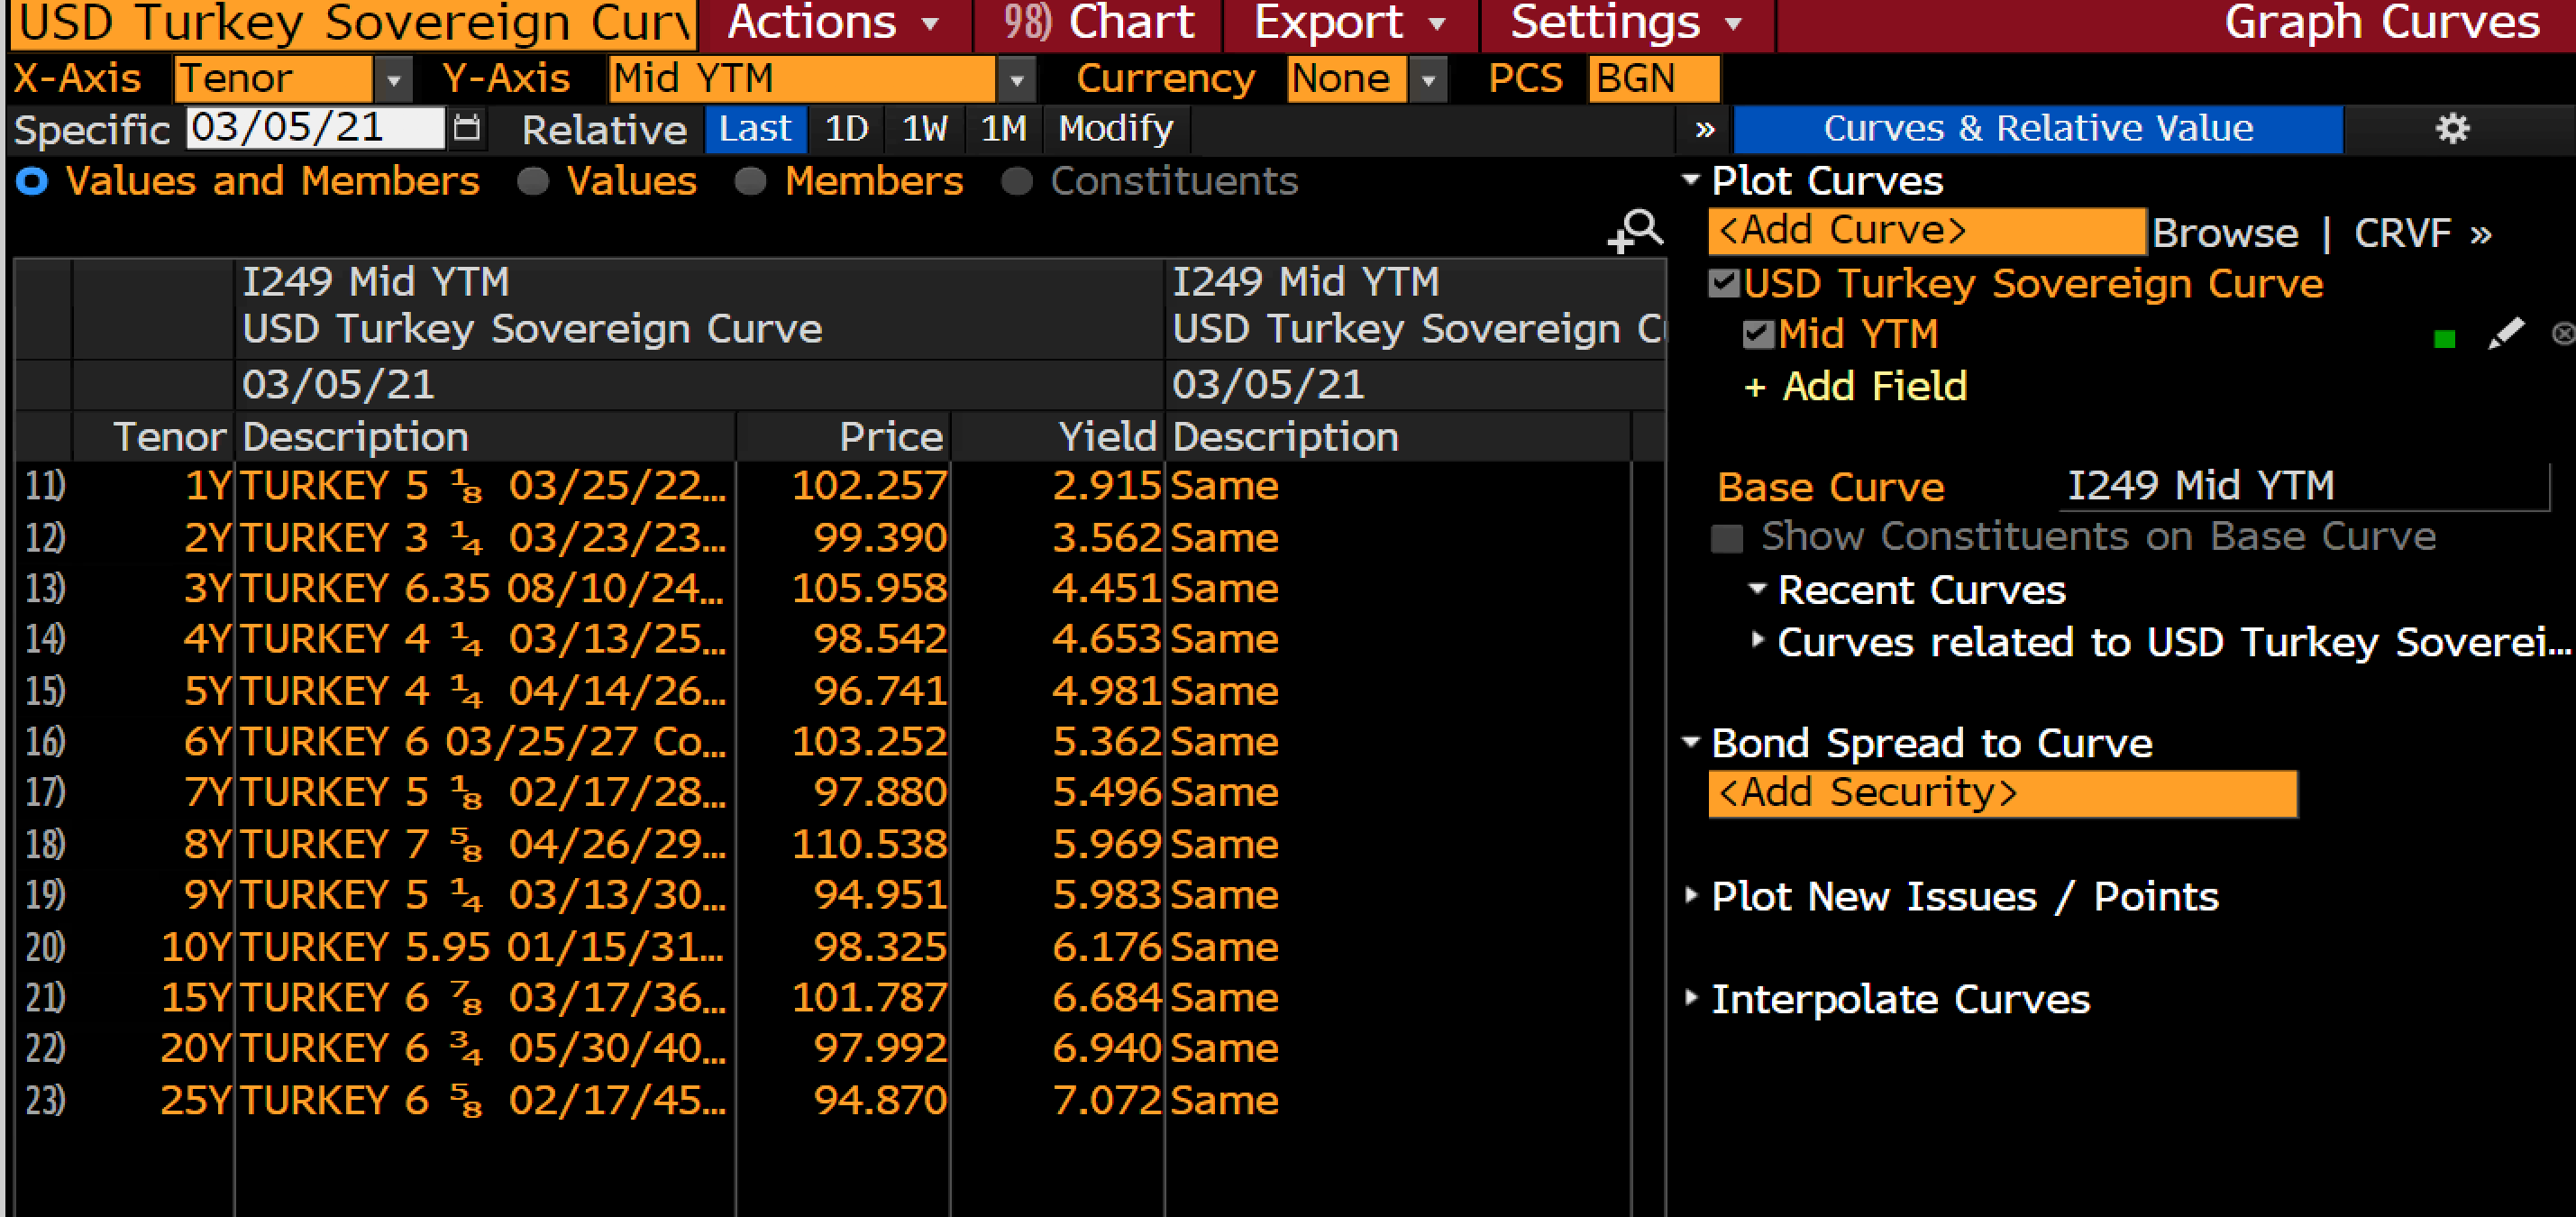

In [12]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['Clean Price', result.get('cleanPrice')])
npvTable.add_row(['Dirty Price', result.get('dirtyPrice')])
npvTable.add_row(['Accrued Amount', result.get('accruedAmount')])
npvTable.add_row(['Yield to Maturity', 100*result.get('yieldToMaturity')])
npvTable.add_row(['Duration', result.get('duration')])
npvTable.add_row(['Modified Duration', result.get('modifiedDuration')])
npvTable.add_row(['Macualay Duration', result.get('macaulayDuration')])
npvTable.add_row(['Convexity', result.get('convexity')])
npvTable.add_row(['Bps', result.get('bps')])
npvTable.align = 'r'
npvTable.float_format = '.3'
print(npvTable)



+-------------------+---------+
|        Parameters |   Value |
+-------------------+---------+
|                PV |  95.267 |
|       Clean Price |  94.871 |
|       Dirty Price |  95.275 |
|    Accrued Amount |   0.405 |
| Yield to Maturity |   7.072 |
|          Duration |  11.970 |
| Modified Duration |  11.561 |
| Macualay Duration |  11.970 |
|         Convexity | 203.778 |
|               Bps |   0.115 |
+-------------------+---------+


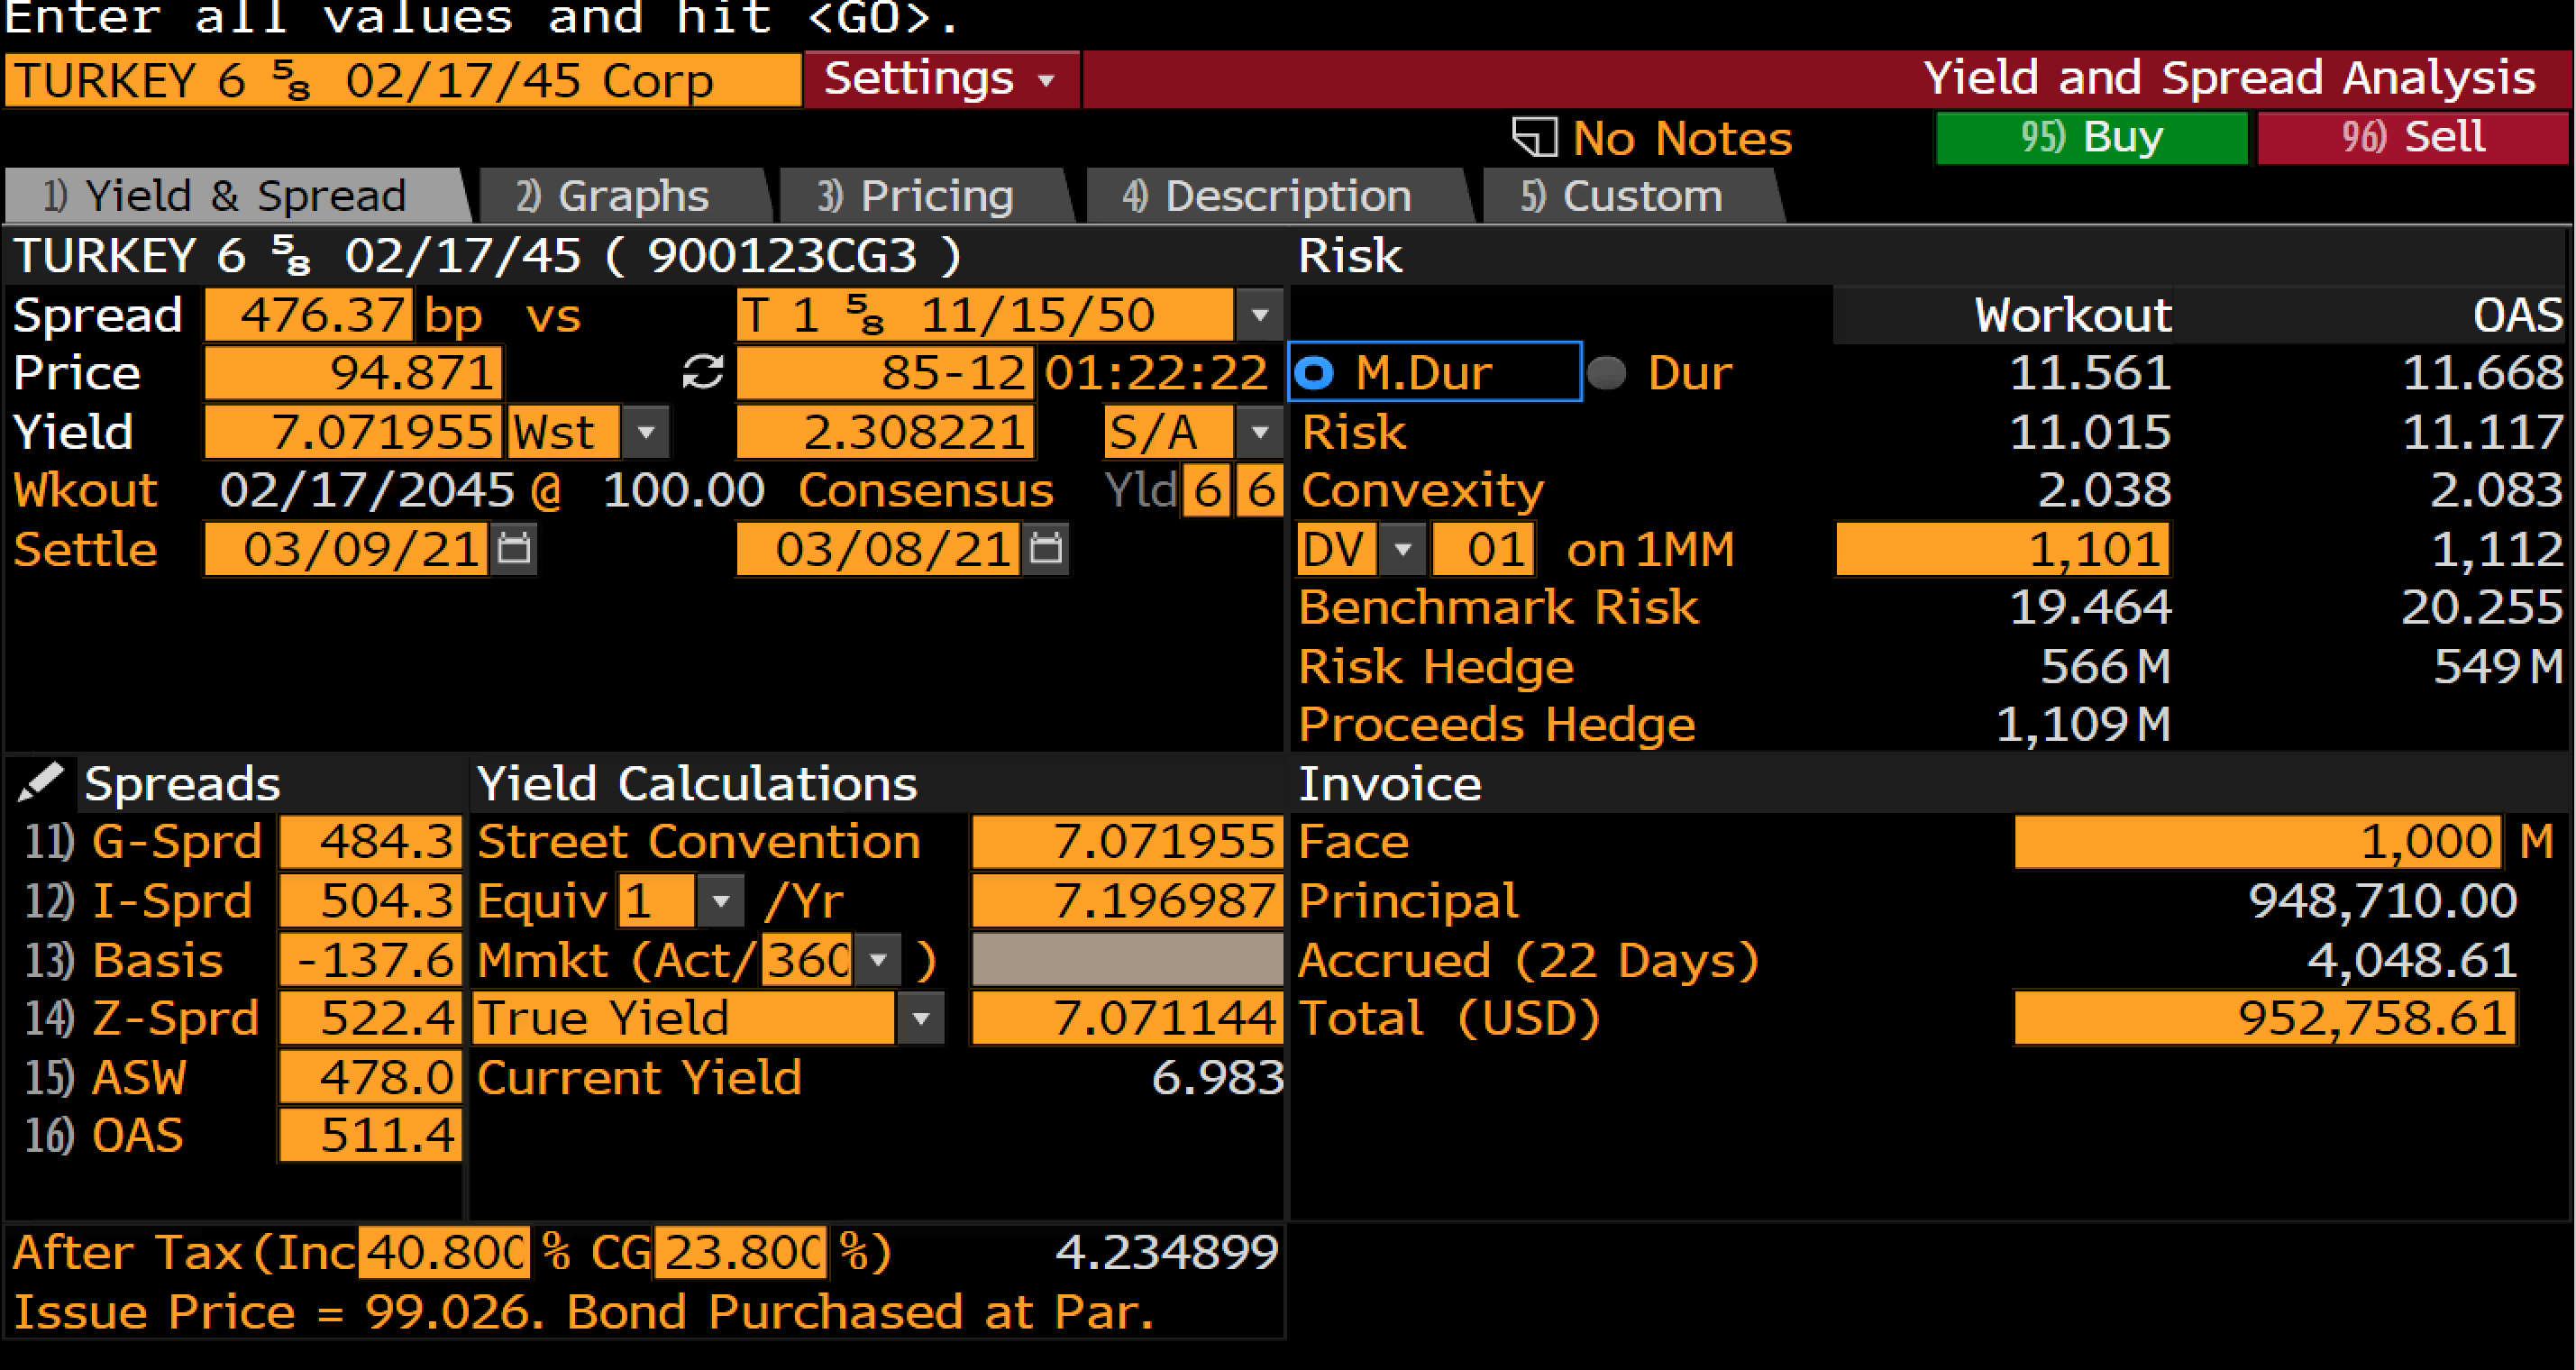